In [1]:

import gc
import time
import numpy as np 
import pandas as pd 
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score , f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

import itertools

import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import re
pd.set_option('display.max_columns', 500)

% matplotlib inline



/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
df= pd.read_csv('../../data/branch/perga_60y_br.csv')

In [3]:
df.shape

(27808, 18)

In [4]:
df.head(10)

,unitig,readid_of_unitig,right_end_A,readid,right_end_T,readid.1,right_end_G,readid.2,right_end_C,readid.3,left_end_A,readid.4,left_end_T,readid.5,left_end_G,readid.6,left_end_C,readid.7
0,TCAACATAGGTGGACATGTTTTTGTTGAAGCAG,2649197#2727003,$,$,$,$,$,$,$,$,GCAGGTTGATTTTGTAATCAACATAGGTGGACATGTTTTTGTTGAAG,101968#155970#298446#309683#347450#504947#5824...,$,$,CGATCTGGTTGATGATGTAGTCAACATAGGTGGACATGTTTTTGTT...,42410#351107#359439#719087#747268#775843#82266...,$,$
1,GAGAGTGCCGGAGATAAGCGCCGGATGGGGGA,2594711#2756162,$,$,$,$,$,$,$,$,$,$,TTCTTATCGCCCCTTCAAGAGCTAAGCCACTGAGAGTGCCGGAGAT...,15672#159156#240858#241952#244541#463075#66394...,$,$,TTCTTATCGCCCCTTCAAGAGCTAAGCCACCGAGAGTGCCGGAGAT...,2276450#2756162
2,GCAAATGCCTGATGCGCTACGCTTATTAGGCCTAC,1050832#2475118#2546684#2568398,TGCCTGATGCGCTACGCTTATTAGGCCTACA,595206#1050832#2032226#2264000#2475118#2546684,$,$,TGCCTGATGCGCTACGCTTATTAGGCCTACG,540198#1201428#1292274,$,$,$,$,$,$,$,$,$,$
3,GGGCGTAGCGAGCGAATACCTGCGGATGCGGTGCCCA,2488037#2772435,$,$,$,$,$,$,$,$,$,$,TCAGGCATTGCTGCCCCGCTCTGATAATGCTGGGCGTAGCGAGCGA...,49047#967748,$,$,TCAGGCATTGCTGCCCCGCTCTGATAATGCCGGGCGTAGCGAGCGA...,33076#184415#194838#282120#309575#478185#55726...
4,ACGAAAAAAAGAAAGGCGTGCATACCCGCTTTTTAATATTACTGAT...,2364150#2364660,$,$,TTTAATATTACTGATTATTTTTATTGTTACTGCCG,783827#2433853,$,$,TTTAATATTACTGATTATTTTTATTGTTACCGCCGTTAACTACGCC...,5785#69774#84365#95526#137461#162958#213089#22...,$,$,$,$,CCTTATGTGCATATGCTCAAAATAATATTTAAATAGTATTAATTAA...,50651#125912#131143#133958#139871#250487#26966...,$,$
5,TGCCCATATCCAGACCAACCACTTTACCGGTGTATTTCACATCATC...,5803#6676#16930#24595#25436#30536#44744#47294#...,$,$,CCAGAGTTGATGCAGGCAGTTATGCTGCGGTGGTAAAACCTCGCGC...,156552#214824#229061#232578#365389#370640#3863...,CCAGAGTTGATGCAGGCAGTTATGCTGCGGGGGTAAAA,1068591#2591479,$,$,$,$,$,$,ACAATCCCCTGAATCACGCGGAAGAAGATCAGCATATTCAGGCTGC...,5724#17534#31210#34896#62861#88806#90938#11944...,$,$
6,TTCTTATCGCCCCTTCAAGAGCTAAGCCACCGAGAGTGCCGGAGAT...,2276450#2756162,$,$,GAGAGTGCCGGAGATAAGCGCCGGATGGGGTAGAAACCCTTAAGCC...,14264#15290#15672#20271#22442#23806#31843#3230...,GAGAGTGCCGGAGATAAGCGCCGGATGGGGGA,2594711#2756162,$,$,GTGCATTGATCCTGACTTAATGCCGCAAGTTCGCCAAATCGACCTG...,41086#77993#126100#159156#208386#241952#382952...,$,$,$,$,$,$
7,GATATTTCTATTATCGAAATCGACGAAGTTGACGGCGAAAAAACCT...,4942#10247#13073#19746#34818#44803#48822#65000...,$,$,GCAGCAACATGCCCAGCAGCAGACTGCCGGTGCTGATGCTTCTGCA...,32725#151965#159948#231953#288378#333078#36752...,GCAGCAACATGCCCAGCAGCAGACTGCCGGGGCTGATGCTTCTGCA...,933784#2420294,$,$,$,$,$,$,$,$,CAACCGTACTATCGCGGTTTATGACCTGGGTGGTGGTACTTTCGAT...,77130#250536#316348#325601#342015#367560#42417...
8,CTATTTAGACCGTTTCTTCGCCATTTAAGGTGTTATCCCCA,2247544#2471821,$,$,$,$,$,$,$,$,CTTGAATCAGACTATTTAGACCGTTTCTTCGCCATTTAAGG,1180673#2471821,$,$,$,$,AATCAGCCTATTTAGACCGTTTCTTCGCCATTTAAGG,228#1521#21615#84724#89717#95111#103348#106641...
9,TGCCGGATGCGGCGTGAACGCCTTATCCGGGCTAC,141761#2231433#2451653,$,$,$,$,$,$,$,$,ATGCCGGATGCGGCGTGAACGCCTTATCCGG,7808#16244#23905#24274#25300#31364#35184#45500...,TTGCCGGATGCGGCGTGAACGCCTTATCCGG,8624#50762#51497#52805#62706#70083#73324#76198...,AGTGCCGGATGCGGCGTGAACGCCTTATCCGG,15611#97829#202178#239179#273739#332922#397285...,CTGCCGGATGCGGCGTGAACGCCTTATCCGG,1399#4411#25249#56104#64151#65979#67639#93267#...


In [5]:
rids_ind = range(1,18,2)
str_ind = range(0,18,2)
rids_ind,str_ind

([1, 3, 5, 7, 9, 11, 13, 15, 17], [0, 2, 4, 6, 8, 10, 12, 14, 16])

In [6]:
gen_unitigs = list(df['unitig'])

In [7]:
len_unitigs= np.array([len(k) for k in gen_unitigs])

In [8]:
len_unitigs.mean()

327.62629459148445

In [9]:
br_inds= str_ind[1:]

In [10]:
br_inds

[2, 4, 6, 8, 10, 12, 14, 16]

In [11]:
all_branches=[]

for i in range(df.shape[0]):
    sd= list(df.loc[i].values)
    for j in br_inds:
        
        if sd[j] != '$':

            all_branches.append(sd[j])



In [12]:
len(all_branches)

89975

In [13]:
len_branches= np.array([len(k) for k in all_branches])

In [14]:
len_branches.mean()

201.29722700750207

In [15]:
len(len_unitigs)

27808

In [16]:
len(len_unitigs[len_unitigs<40])

3216

In [17]:
len(all_branches)

89975

In [18]:
right_inds= br_inds[:4]
left_inds= br_inds[4:]
right_inds, left_inds

([2, 4, 6, 8], [10, 12, 14, 16])

In [19]:
%%time
pos_contigs =[]
for i in range(df.shape[0]):
    sd= list(df.loc[i].values)    
    primary = str(sd[0])
    prids =sd[1].split('#')
    for k in right_inds:
        if sd[k] != '$':
            rids= sd[k+1].split('#')
            rcount =0
            pcount =0
            for rid in rids:
                if rid in prids:
                    rcount+=1
                
                if int(rid) % 2 ==0:
                    if str(int(rid)-1 ) in prids:
                        pcount+=1
                else:
                    if str(int(rid)+1 ) in prids:
                        pcount+=1
                
                    
            contig= primary + str(sd[k])[31:]
            pos_contigs.append((contig,rcount, pcount) )
            
    for k in left_inds:
        if sd[k] != '$':
            rids= sd[k+1].split('#')
            rcount =0
            pcount =0
            for rid in rids:
                if rid in prids:
                    rcount+=1
                
                if int(rid) % 2 ==0:
                    if str(int(rid)-1 ) in prids:
                        pcount+=1
                else:
                    if str(int(rid)+1 ) in prids:
                        pcount+=1
            contig=  str(sd[k])[:-31] + primary  
            pos_contigs.append((contig,rcount, pcount) )




CPU times: user 29.5 s, sys: 695 ms, total: 30.2 s
Wall time: 29.8 s


In [49]:
pos_contigs[:5]

[('GCAGGTTGATTTTGTATCAACATAGGTGGACATGTTTTTGTTGAAGCAG', 1, 0),
 ('CGATCTGGTTGATGATGTATCAACATAGGTGGACATGTTTTTGTTGAAGCAG', 1, 0),
 ('TTCTTATCGCCCCTTCAAGAGCTAAGCCACGAGAGTGCCGGAGATAAGCGCCGGATGGGGGA', 1, 0),
 ('TTCTTATCGCCCCTTCAAGAGCTAAGCCACGAGAGTGCCGGAGATAAGCGCCGGATGGGGGA', 1, 0),
 ('GCAAATGCCTGATGCGCTACGCTTATTAGGCCTAC', 3, 0)]

In [21]:
ris = np.array([i[1] for i in pos_contigs])

In [21]:
ris

array([ 1,  1,  1, ..., 19, 22, 41])

In [22]:
ris.mean(), ris.max(), ris.std()

(18.884012225618228, 895, 29.711659349884037)

In [24]:
rixs = [i[2] for i in pos_contigs]

In [27]:
df.head()

,unitig,readid_of_unitig,right_end_A,readid,right_end_T,readid.1,right_end_G,readid.2,right_end_C,readid.3,left_end_A,readid.4,left_end_T,readid.5,left_end_G,readid.6,left_end_C,readid.7
0,TCAACATAGGTGGACATGTTTTTGTTGAAGCAG,2649197#2727003,$,$,$,$,$,$,$,$,GCAGGTTGATTTTGTAATCAACATAGGTGGACATGTTTTTGTTGAAG,101968#155970#298446#309683#347450#504947#5824...,$,$,CGATCTGGTTGATGATGTAGTCAACATAGGTGGACATGTTTTTGTT...,42410#351107#359439#719087#747268#775843#82266...,$,$
1,GAGAGTGCCGGAGATAAGCGCCGGATGGGGGA,2594711#2756162,$,$,$,$,$,$,$,$,$,$,TTCTTATCGCCCCTTCAAGAGCTAAGCCACTGAGAGTGCCGGAGAT...,15672#159156#240858#241952#244541#463075#66394...,$,$,TTCTTATCGCCCCTTCAAGAGCTAAGCCACCGAGAGTGCCGGAGAT...,2276450#2756162
2,GCAAATGCCTGATGCGCTACGCTTATTAGGCCTAC,1050832#2475118#2546684#2568398,TGCCTGATGCGCTACGCTTATTAGGCCTACA,595206#1050832#2032226#2264000#2475118#2546684,$,$,TGCCTGATGCGCTACGCTTATTAGGCCTACG,540198#1201428#1292274,$,$,$,$,$,$,$,$,$,$
3,GGGCGTAGCGAGCGAATACCTGCGGATGCGGTGCCCA,2488037#2772435,$,$,$,$,$,$,$,$,$,$,TCAGGCATTGCTGCCCCGCTCTGATAATGCTGGGCGTAGCGAGCGA...,49047#967748,$,$,TCAGGCATTGCTGCCCCGCTCTGATAATGCCGGGCGTAGCGAGCGA...,33076#184415#194838#282120#309575#478185#55726...
4,ACGAAAAAAAGAAAGGCGTGCATACCCGCTTTTTAATATTACTGAT...,2364150#2364660,$,$,TTTAATATTACTGATTATTTTTATTGTTACTGCCG,783827#2433853,$,$,TTTAATATTACTGATTATTTTTATTGTTACCGCCGTTAACTACGCC...,5785#69774#84365#95526#137461#162958#213089#22...,$,$,$,$,CCTTATGTGCATATGCTCAAAATAATATTTAAATAGTATTAATTAA...,50651#125912#131143#133958#139871#250487#26966...,$,$


In [46]:
len(pos_contigs)

89975

In [47]:
len_contigs= np.array([len(k) for k in pos_contigs])

In [48]:
len_contigs.mean()

3.0

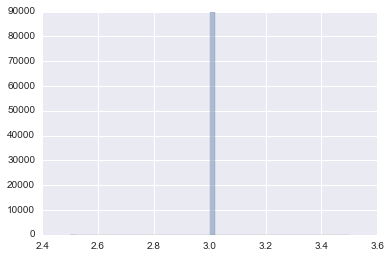

In [31]:
sns.distplot(len_contigs, kde=False)

In [24]:
fo = open('../../data/branch/60yn_pos_contigs.fa','w')

In [25]:
for i in range(len(pos_contigs)):
    fo.write('>_'+ str(i)+'\n'+ pos_contigs[i]+ '\n' )

In [26]:
fo.close()

In [41]:
pwd

u'/Users/satwikb/Work/Adapt/work/code/Untitled Folder'

In [52]:
feats = pd.read_csv('../data/features/60yn_pos_contigs_all_features.csv')

In [53]:
feats.shape

(5000, 8)

In [54]:
feats.head()

,ID,Core_length,Dev_from_max,Dev_from_min,Dev_from_avg,Dev_from_med,Dev_from_N50,Dev_from_L50
0,_0,49,4286,18,445,305,0.059611,0.078150
1,_1,52,4283,21,442,302,0.063260,0.082935
2,_2,62,4273,31,432,292,0.075426,0.098884
3,_3,62,4273,31,432,292,0.075426,0.098884
4,_4,35,4300,4,459,319,0.042579,0.055821


In [55]:
qual_syn60 = pd.read_csv('../data/quality/60x_pos_contigs_cleaned.csv')

In [56]:
qual_syn60.head()

,ID,Quality_Score
0,_56778,0.255
1,_56779,0.376
2,_56770,0.394
3,_56771,0.350
4,_56772,0.334


In [57]:
full_df = feats.merge(qual_syn60)

In [58]:
full_df.head()

,ID,Core_length,Dev_from_max,Dev_from_min,Dev_from_avg,Dev_from_med,Dev_from_N50,Dev_from_L50,Quality_Score
0,_0,49,4286,18,445,305,0.059611,0.078150,0.0
1,_1,52,4283,21,442,302,0.063260,0.082935,0.0
2,_2,62,4273,31,432,292,0.075426,0.098884,0.0
3,_3,62,4273,31,432,292,0.075426,0.098884,0.0
4,_4,35,4300,4,459,319,0.042579,0.055821,0.0


In [59]:
full_df.describe()

,Core_length,Dev_from_max,Dev_from_min,Dev_from_avg,Dev_from_med,Dev_from_N50,Dev_from_L50,Quality_Score
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,933.378200,3401.621800,902.378200,534.961800,618.184600,1.135497,1.488641,0.370825
std,606.191803,606.191803,606.191803,523.754663,566.556356,0.737460,0.966813,0.057537
min,35.000000,0.000000,4.000000,0.000000,0.000000,0.042579,0.055821,0.000000
25%,481.750000,3082.000000,450.750000,159.000000,180.000000,0.586071,0.768341,0.350000
50%,804.500000,3530.500000,773.500000,356.000000,450.500000,0.978710,1.283094,0.379000
75%,1253.000000,3853.250000,1222.000000,759.000000,899.000000,1.524331,1.998405,0.404000
max,4335.000000,4300.000000,4304.000000,3841.000000,3981.000000,5.273723,6.913876,0.474000


In [60]:
full_df.head()

,ID,Core_length,Dev_from_max,Dev_from_min,Dev_from_avg,Dev_from_med,Dev_from_N50,Dev_from_L50,Quality_Score
0,_0,49,4286,18,445,305,0.059611,0.078150,0.0
1,_1,52,4283,21,442,302,0.063260,0.082935,0.0
2,_2,62,4273,31,432,292,0.075426,0.098884,0.0
3,_3,62,4273,31,432,292,0.075426,0.098884,0.0
4,_4,35,4300,4,459,319,0.042579,0.055821,0.0


In [61]:
full_df = full_df.set_index('ID')

In [62]:
xsyn_df = full_df.copy()
qual = np.array(xsyn_df.Quality_Score)
qual[qual >0.42] =5
qual[(qual >0.38) & (qual <=0.42)] =4
qual[(qual >0.35) & (qual <=0.38)] =3
qual[(qual >0.3) & (qual <=0.35)] =2
qual[(qual >0.0) & (qual <=0.3)] =1
qual[qual ==0.0] =0

xsyn_df.Quality_Score = qual


In [63]:
xsyn_df.Quality_Score.value_counts()

4.0    1853
3.0    1293
2.0     994
5.0     571
1.0     226
0.0      63
Name: Quality_Score, dtype: int64

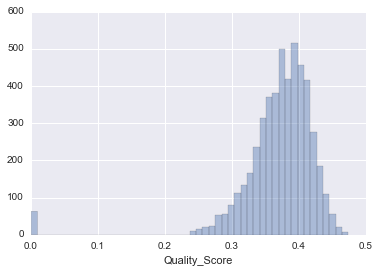

In [64]:
sns.distplot(full_df['Quality_Score'], kde=False)

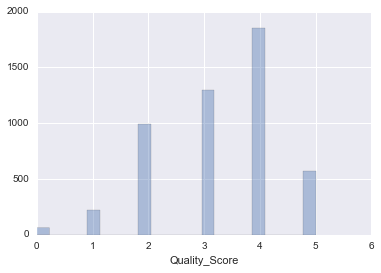

In [65]:
sns.distplot(xsyn_df['Quality_Score'], kde=False)

In [66]:
xsyn_df.head()

,Core_length,Dev_from_max,Dev_from_min,Dev_from_avg,Dev_from_med,Dev_from_N50,Dev_from_L50,Quality_Score
ID,,,,,,,,
_0,49,4286,18,445,305,0.059611,0.078150,0.0
_1,52,4283,21,442,302,0.063260,0.082935,0.0
_2,62,4273,31,432,292,0.075426,0.098884,0.0
_3,62,4273,31,432,292,0.075426,0.098884,0.0
_4,35,4300,4,459,319,0.042579,0.055821,0.0


In [67]:
xsyn_df.dtypes

Core_length        int64
Dev_from_max       int64
Dev_from_min       int64
Dev_from_avg       int64
Dev_from_med       int64
Dev_from_N50     float64
Dev_from_L50     float64
Quality_Score    float64
dtype: object

In [68]:
X_train, X_val, y_train, y_val = train_test_split(xsyn_df.drop('Quality_Score', axis=1), xsyn_df['Quality_Score'],
                                                    test_size=0.3, random_state=42)


In [69]:
lr = LogisticRegression(C=1, penalty='l1')
lr.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [70]:
preds = lr.predict(X_val)

In [148]:
score =0
folds=5
for i in range(folds):
    X_train, X_val, y_train, y_val = train_test_split(xsyn_df.drop('Quality_Score', axis=1), xsyn_df['Quality_Score'],
                                                    test_size=0.3, random_state=i)

    lr = LogisticRegression(C=0.05)
    lr.fit(X_train, y_train)
    preds = lr.predict(X_val)
    f1s = f1_score(y_val, preds, average='weighted')*100 
    print "Fold:", i, "F1 Score:", f1s
    score+=f1s
score/=folds
print "Cross Validation Score: ", score
    

Fold: 0 F1 Score: 98.0437364455
Fold: 1 F1 Score: 98.3620539092
Fold: 2 F1 Score: 97.4698081878
Fold: 3 F1 Score: 97.4786152333
Fold: 4 F1 Score: 97.6233639962
Cross Validation Score:  97.7955155544


In [149]:

rf_model = RandomForestClassifier(n_estimators=10,max_depth=6, n_jobs=-1)
rf_model.fit(X_train, y_train)

preds= rf_model.predict_proba(X_val)

y_preds=[]
for i in preds:
    y_preds.append(np.argmax(i))
    
print "F1 Score:",f1_score(y_val, y_preds, average='weighted')*100 

F1 Score: 99.2694475806


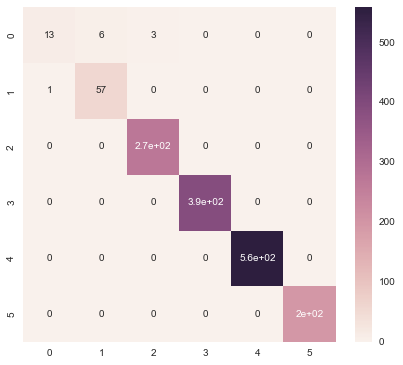

In [150]:
plt.figure(figsize=(7,6))
plt.xlabel('Predicted')
plt.ylabel('True')
sns.heatmap(confusion_matrix(y_val, y_preds) , annot=True)

In [71]:
import tensorflow as tf

n_input = X_train.shape[1]
n_output= 6
net_input = tf.placeholder(tf.float32, [None, n_input])

W = tf.Variable(tf.zeros([n_input, n_output]))
b = tf.Variable(tf.zeros([n_output]))
net_output = tf.nn.softmax(tf.matmul(net_input, W) + b)
y_true = tf.placeholder(tf.float32, [None, 6])

cross_entropy = -tf.reduce_sum(y_true * tf.log(net_output))

correct_prediction = tf.equal(
    tf.argmax(net_output, 1), tf.argmax(y_true, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

optimizer = tf.train.GradientDescentOptimizer(
    0.01).minimize(cross_entropy)



In [72]:

X_train, X_val, y_train, y_val = train_test_split(xsyn_df.drop('Quality_Score', axis=1), xsyn_df['Quality_Score'],
                                                    test_size=0.3, random_state=42)

# y_trainx= tf.one_hot(y_train.values, 6)
# y_valx= tf.one_hot(y_val.values, 6)

In [73]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [74]:
saver = tf.train.Saver()
tf.train.write_graph(sess.graph_def,
                         './model/',
                         'mlp.pb', as_text=False)

'./model/mlp.pb'

In [75]:
a=np.array(y_train.values, dtype=np.int32)
n_values = np.max(a) + 1
y_trainx=np.eye(n_values)[a]

In [76]:
a=np.array(y_val.values, dtype=np.int32)
n_values = np.max(a) + 1
y_valx=np.eye(n_values)[a]

In [77]:
np.max(a)

5

In [78]:
y_valz =y_val.values-1


In [ ]:
data= X_train.values
batch_size=10
n_epochs = 10
for epoch_i in range(n_epochs):
    for batch_i in range(X_train.shape[0] // batch_size):
        batch_xs = X_train.values[batch_i*batch_size:(batch_i+1)*batch_size]
        batch_ys= y_trainx[batch_i*batch_size:(batch_i+1)*batch_size]
        sess.run(optimizer, feed_dict={
            net_input: batch_xs,
            y_true: batch_ys
        })
    print(sess.run(accuracy,
                   feed_dict={
                       net_input: X_val,
                       y_true: y_valx
                   }))

In [80]:
saver.save(sess, './model/tf_model',global_step=1000)

'./model/tf_model-1000'